# Interview Assignment

In [1]:
import os, random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

HTTP_METHODS = ['GET', 'HEAD', 'POST', 'PUT', 'DELETE', 'CONNECT', 'OPTIONS', 'TRACE', 'PATCH']

First we load individual requests from dataset. `load_requests_from_file` splits the files at the HTTP_METHODS keywords. `load_dataset` then merges train and test data in order to use supervised learning and adds coresponding labels. Finally `shuffle_requests_and_labels` shuffles requests and labels with same seed.

##### Labels
* 0 - normal request
* 1 - anomalous request

In [2]:
def load_requests_from_file(fname):
    requests = []
    
    with open(fname) as f:
        request = ""
        for line in f:
            if line.split(" ")[0] in HTTP_METHODS and len(request) > 0:
                requests.append(request.strip())
                request = ""
            request = request + line
            
    return requests

def load_dataset(dataset_dir):
    train_normal_requests = load_requests_from_file(os.path.join(dataset_dir, 'normalTrafficTraining.txt'))
    test_normal_requests = load_requests_from_file(os.path.join(dataset_dir, 'normalTrafficTest.txt'))
    test_anomalous_requests = load_requests_from_file(os.path.join(dataset_dir, 'anomalousTrafficTest.txt'))

    requests = []
    labels = []
    
    for request in train_normal_requests + test_normal_requests:
        requests.append(request)
        labels.append(0) # 0 for normal
        
    for request in test_anomalous_requests:
        requests.append(request)
        labels.append(1) # 1 for anomalous
    
    return (requests, labels)

def shuffle_requests_and_labels(requests, labels, seed=123):
    random.seed(seed)
    random.shuffle(requests)
    random.seed(seed)
    random.shuffle(labels)
    
    return (requests, labels)

(requests, labels) = load_dataset('dataset')
(requests, labels) = shuffle_requests_and_labels(requests, labels)

Because we merged train and test data (in order to get labeled dataset), we now have to split the data in two labeled train and test sets. We use 80% for training data and 20% for test data.

In [3]:
boundary = int(len(requests)*0.8)
X_train = requests[:boundary]
y_train = np.array(labels[:boundary])

X_test = requests[boundary:]
y_test = np.array(labels[boundary:])

In [4]:
# Get smaller samples from both tests for faster debugging
# X_train = X_train[:5000]
# y_train = y_train[:5000]

# X_test = X_test[:500]
# y_test = y_test[:500]

Now we get some metrics from the training set and plot some of it features. We can see from the output that the dataset is imbalanced with aprox. 3:1 ratio.

Training set:
Total # of requests: 77649
# of normal requests: 57605
# of anomalous requests: 20044
normal/anomalous ratio: 2.8739273598084214


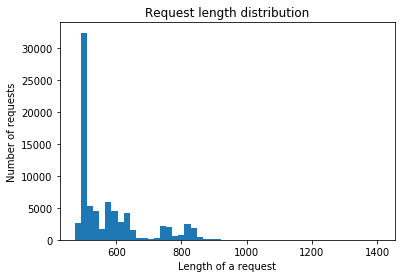

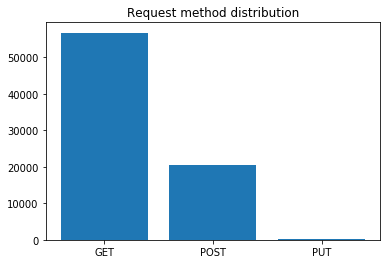

In [5]:
def plot_request_length_distribution(requests):
    plt.hist([len(r) for r in requests], 50)
    plt.xlabel('Length of a request')
    plt.ylabel('Number of requests')
    plt.title('Request length distribution')
    plt.show()
    
def plot_request_method_distribution(requests):
    counter = Counter([r.split(" ")[0] for r in requests])
    plt.bar(range(len(counter)), list(counter.values()))
    plt.xticks(range(len(counter)), list(counter.keys()))
    plt.title('Request method distribution')
    plt.show()

print("Training set:")
print("Total # of requests: {}".format(len(X_train)))
print("# of normal requests: {}".format(np.count_nonzero(y_train == 0)))
print("# of anomalous requests: {}".format(np.count_nonzero(y_train == 1)))
print("normal/anomalous ratio: {}".format(np.count_nonzero(y_train == 0)/np.count_nonzero(y_train == 1)))
plot_request_length_distribution(X_train)
plot_request_method_distribution(X_train)

Now we can tokenize and vectorize both of our sets.

In [6]:
N_GRAMS_SIZE = (3, 3) # sizes of n-grams to be used
MIN_DF = 2 # minimal occurences of token for it to appear in features
MAX_FEATURES = 20000 # Maximum number of top features to select 

def tokenize_and_vectorize(train_requests, train_labels, test_requests):
    kwargs = {
                'ngram_range': N_GRAMS_SIZE,
                'strip_accents': 'unicode',
                'decode_error': 'replace',
                'analyzer': 'char',
                'min_df': MIN_DF
        }

    vectorizer = TfidfVectorizer(**kwargs)

    x_train = vectorizer.fit_transform(train_requests)
    x_test = vectorizer.transform(test_requests)
    
    selector = SelectKBest(f_classif, k=min(MAX_FEATURES, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_test = selector.transform(x_test)

    return x_train, x_test
    
X_train, X_test = tokenize_and_vectorize(X_train, y_train, X_test)

Now is the time for the classifier.

In [7]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('{} / {} correct. Accuracy: {}'.format(num_correct, X_test.shape[0], accuracy))

19273 / 19413 correct. Accuracy: 0.9927883377118426
